# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from pygsti.modelpacks import smq2Q_XYICNOT as std

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements


### Loading data

In [4]:
with open('data/20230504-1132_cgst_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']
d = 6

### GST

Starting optimization...
100%|██████████| 200/200 [05:00<00:00,  1.50s/it]


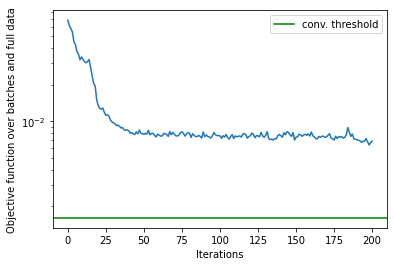

Success threshold not reached, attempting optimization over full data set...
100%|██████████| 140/140 [26:07<00:00, 11.20s/it]


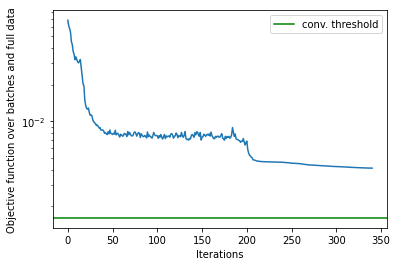

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.004118324255057095 with # of initializations: 1 
 	 Total runtime: 1869.0369348526


In [73]:
bsize = 120   # The batch size on which the optimization is started
results = []
for rK in [16]:  
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/w)-Y(pi/2) model 
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
    X_t[[1,2,3,4],:,:] = X_t[[3,4,1,2],:,:] #swap gate ordering for consistency
    K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
                         max_inits = 10, max_iter = 200, final_iter = 140, threshold_multiplyer = 100, 
                         target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
#     K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
#                          max_inits = 10, max_iter = 0, final_iter = 10, threshold_multiplyer = 100, 
#                          target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
    results.append([K,X,E,rho])

In [78]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [93]:
# ###################################### 
# filename = 'ranks_16_from_init'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all,'y':y_all,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
def MVE_data(X, E, rho, J, y):
    m = y.shape[1]
    n_povm = y.shape[0]
    dist: float = 0
    max_dist: float = 0
    curr: float = 0
    for i in range(m):
        j = J[i]
        C = low_level_jit.contract(X, j)
        curr = 0
        for k in range(n_povm):
            y_model = E[k].conj()@C@rho
            curr += np.abs(y_model - y[k, i])
        curr = curr/2
        dist += curr
        if curr > max_dist:
            max_dist = curr
    return dist/m, max_dist

In [94]:
def gauge_opt_report(X, E, rho, J, y, weights):
    mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

    gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
                item_weights=weights)
    X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')    
    
    final_objf = low_level_jit.objf(X,E,rho,J,y)
    MVE = MVE_data(X,E,rho,J,y)[0]
    MVE_target = MVE_data(X_t,E_t,rho_t,J,y)[0]
    povm_td = rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault')
    rho_td = la.norm(rho_opt-rho_t,ord = 1)/2
    F_avg = compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp')
    DD = compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp')
    

    df_g = pd.DataFrame({
        "F_avg":F_avg,
        "Diamond distances": DD
    })
    df_o = pd.DataFrame({
        "Final cost function value": final_objf,
        "Mean total variation dist. to data": MVE,
        "Mean total variation dist. target to data": MVE_target,
        "POVM - Choi map trace distance": povm_td,
        "State - Trace distance": rho_td,  
    }, index = [0])
    df_g.rename(index={0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}, inplace = True)
    df_o.rename(index={0: ""}, inplace = True)
    
    s_g = df_g.style.format(precision=5, thousands=".", decimal=",")
    s_o = df_o.style
    
    s_g.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
    {'selector': 'td', 'props': 'text-align: center'},
    ], overwrite=False)
    s_o.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
    {'selector': 'td', 'props': 'text-align: center'},
    ], overwrite=False)
    return df_g, df_o, s_g, s_o, gauge_optimized_mdl

In [62]:
with open("ranks_4_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [95]:
#K,X,E,rho = results[0][:]
df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(X, E, rho, J_all, y_all, weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5':1, 'spam': 1})

In [96]:
X_pp, E_pp, rho_pp = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'pp')
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'pp')
display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99985","0,01413"
Rx(pi/2)[q0],"0,99397","0,05215"
Ry(pi/2)[q0],"0,99344","0,06311"
Rx(pi/2)[q1],"0,96317","0,17228"
Ry(pi/2)[q1],"0,96235","0,13657"
CNOT[q0-q1],"0,39724","0,99588"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004028,0.080832,0.357838,0.517189,0.153710


(None, None)

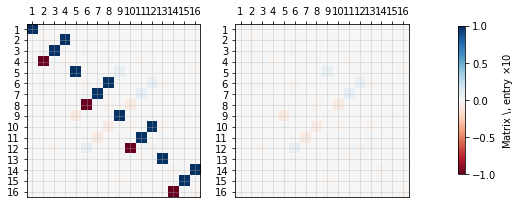

In [99]:
fig, axes = plt.subplots(ncols=2, nrows = 1,gridspec_kw={"width_ratios":[1,1]}, sharex=True)
gate_index = 2
plt.rc('image', cmap='RdBu')
ax = axes[0]
im0 = ax.imshow(np.real(X_pp[gate_index]), vmin = -1, vmax = 1) #change_basis(S_true_maps[0],'std','pp')
ax.set_xticks(np.arange(16))
ax.set_xticklabels(np.arange(16)+1)
ax.set_yticks(np.arange(16))
ax.set_yticklabels(np.arange(16)+1)
ax.grid(visible = 'True', alpha = 0.4)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax = axes[1]
im1 = ax.imshow(np.real(X_pp[gate_index]-X_t_pp[gate_index]), vmin = -1, vmax = 1) #change_basis(S_true_maps[0],'std','pp')
ax.set_xticks(np.arange(16))
ax.set_xticklabels(np.arange(16)+1)
ax.set_yticks(np.arange(16))
ax.set_yticklabels(np.arange(16)+1)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.grid(visible = 'True', alpha = 0.4)
# axes[0].set_title(r'$\bar{F}_{\mathrm{avg.}} = 0.954$')
# axes[1].set_title(r'$\bar{F}_{\mathrm{avg.}} = 0.995$')

# cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0-0.05,0.02,ax.get_position().height])
#fig.colorbar(im1, cax=cax)
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), pad = 0.1)
cbar.ax.set_ylabel(r'Matrix \, entry $\times 10$', labelpad = 5, rotation=90)


fig.subplots_adjust(left = 0.05, right = .7, top = 1, bottom = -.1)

set_size(5.3,3)

#plt.savefig('data/noisy_frame_ops.pdf', dpi=150, transparent=True)
plt.show()